## Calibration Workshop

https://www.youtube.com/watch?v=QUXfYgGlwtU

In this Notebook we will:
- Load data and train a model
- Assess the Calibration of the model
- Explore various methods to calibrate the results of the model

Notebook requires `numpy`, `pandas`, `scikit-learn` as well as the `ml-insights` and `betacal` packages

In [1]:
# !pip install ml_insights
# !pip install betacal

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ml_insights as mli
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, brier_score_loss, roc_auc_score
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from betacal import BetaCalibration
mli.__version__

'1.0.0'

### MIMIC ICU Data*

We illustrate calibration using a mortality model on the MIMIC ICU data.  Each row represents a hospital stay of an individual patient.  We have many lab values and vital sign measurements, as well as an indicator of whether or not the patient died in the hospital.

*MIMIC-III, a freely accessible critical care database. Johnson AEW, Pollard TJ, Shen L, Lehman L, Feng M, Ghassemi M, Moody B, Szolovits P, Celi LA, and Mark RG. Scientific Data (2016).
https://mimic.physionet.org

In [2]:
# Load dataset derived from the MMIC database
lab_aug_df = pd.read_csv("calibration_workshop_data.csv")

In [3]:
lab_aug_df.head()

,subject_id,hadm_id,icustay_id,aniongap_min,aniongap_max,albumin_min,albumin_max,bicarbonate_min,bicarbonate_max,bilirubin_min,...,meanbp_mean,resprate_min,resprate_max,resprate_mean,tempc_min,tempc_max,tempc_mean,spo2_min,spo2_max,spo2_mean
0,9,150750,220597,13.0,13.0,NaN,NaN,26.0,30.0,0.4,...,98.850000,14.0,19.0,14.369565,35.500001,37.888887,37.049383,95.0,100.0,97.650000
1,13,143045,263738,10.0,14.0,3.9,3.9,23.0,24.0,0.4,...,93.772727,11.0,25.0,15.320000,35.944443,37.400002,36.653534,94.0,100.0,97.700000
2,20,157681,264490,12.0,12.0,NaN,NaN,21.0,21.0,NaN,...,75.058333,10.0,27.0,15.404762,35.900002,37.299999,36.545714,95.0,100.0,98.435897
3,28,162569,225559,13.0,13.0,NaN,NaN,23.0,23.0,NaN,...,69.133333,9.0,32.0,16.677419,35.900002,37.700001,37.033333,92.0,100.0,96.419355
4,37,188670,213503,9.0,10.0,NaN,NaN,33.0,35.0,NaN,...,73.297610,15.0,30.0,22.241379,36.833335,38.055556,37.333334,89.0,99.0,96.533333


In [4]:
lab_aug_df.describe()

,subject_id,hadm_id,icustay_id,aniongap_min,aniongap_max,albumin_min,albumin_max,bicarbonate_min,bicarbonate_max,bilirubin_min,...,meanbp_mean,resprate_min,resprate_max,resprate_mean,tempc_min,tempc_max,tempc_mean,spo2_min,spo2_max,spo2_mean
count,59726.000000,59726.000000,59726.000000,52706.000000,52706.000000,19066.000000,19066.000000,53429.000000,53429.000000,25405.000000,...,51902.000000,51854.000000,51854.000000,51854.000000,51052.000000,51052.000000,51052.000000,51852.000000,51852.000000,51852.000000
mean,34190.210779,149957.727321,249973.440244,13.037472,15.744868,3.117455,3.202759,22.683341,25.087030,1.981925,...,77.955104,12.341441,27.312859,18.850614,36.075055,37.476005,36.811690,91.290991,99.554956,97.134255
std,28258.474729,28887.151323,28906.676682,3.387138,4.724261,0.724437,0.713744,4.915263,4.487303,4.140168,...,11.409047,3.757796,6.608627,4.044379,0.811516,0.802000,0.635583,8.952956,1.307470,2.652928
min,2.000000,100001.000000,200001.000000,1.000000,2.000000,1.000000,1.000000,2.000000,5.000000,0.100000,...,17.428571,0.200000,8.000000,7.000000,15.000000,30.000000,30.000000,0.500000,42.000000,31.444444
25%,12143.250000,124971.250000,224933.250000,11.000000,13.000000,2.600000,2.700000,20.000000,22.000000,0.400000,...,70.166667,10.000000,23.000000,16.023256,35.666665,36.944444,36.425926,90.000000,100.000000,96.142143
50%,24506.500000,149893.500000,249960.500000,13.000000,15.000000,3.100000,3.200000,23.000000,25.000000,0.700000,...,76.587980,12.000000,26.000000,18.178571,36.111111,37.388891,36.787037,93.000000,100.000000,97.538462
75%,54903.000000,174977.750000,275013.750000,15.000000,18.000000,3.600000,3.700000,25.000000,27.000000,1.600000,...,84.574107,14.000000,30.000000,21.028373,36.555557,37.944444,37.182540,95.000000,100.000000,98.705882
max,99999.000000,199999.000000,299999.000000,45.000000,59.000000,6.300000,6.300000,52.000000,53.000000,79.000000,...,153.838710,47.000000,69.000000,47.000000,40.833333,46.500000,40.833333,100.000000,100.000000,100.000000


In [5]:
# Impute the median for in each column to replace NA's 
for i in range(len(lab_aug_df.columns)):
    if lab_aug_df.iloc[:,i].dtype!='O':
        lab_aug_df.iloc[:,i].fillna(lab_aug_df.iloc[:,i].median(),inplace=True)

In [6]:
lab_aug_df.head()

,subject_id,hadm_id,icustay_id,aniongap_min,aniongap_max,albumin_min,albumin_max,bicarbonate_min,bicarbonate_max,bilirubin_min,...,meanbp_mean,resprate_min,resprate_max,resprate_mean,tempc_min,tempc_max,tempc_mean,spo2_min,spo2_max,spo2_mean
0,9,150750,220597,13.0,13.0,3.1,3.2,26.0,30.0,0.4,...,98.850000,14.0,19.0,14.369565,35.500001,37.888887,37.049383,95.0,100.0,97.650000
1,13,143045,263738,10.0,14.0,3.9,3.9,23.0,24.0,0.4,...,93.772727,11.0,25.0,15.320000,35.944443,37.400002,36.653534,94.0,100.0,97.700000
2,20,157681,264490,12.0,12.0,3.1,3.2,21.0,21.0,0.7,...,75.058333,10.0,27.0,15.404762,35.900002,37.299999,36.545714,95.0,100.0,98.435897
3,28,162569,225559,13.0,13.0,3.1,3.2,23.0,23.0,0.7,...,69.133333,9.0,32.0,16.677419,35.900002,37.700001,37.033333,92.0,100.0,96.419355
4,37,188670,213503,9.0,10.0,3.1,3.2,33.0,35.0,0.7,...,73.297610,15.0,30.0,22.241379,36.833335,38.055556,37.333334,89.0,99.0,96.533333


## Lesson 1: Assessing Calibration

We will be building a model to predict mortality in the ICU based on vital signs and lab values.  To start, we will just pick a few different ones on which to build our model.

In [7]:
# Choose a subset of variables
feature_set_1 = ['bun_min',
       'bun_max', 'wbc_min', 'wbc_max','sysbp_max', 'sysbp_min']

X_1 = lab_aug_df.loc[:,feature_set_1]
y = lab_aug_df['hospital_expire_flag']

We now divide the data into training, calibration, and test sets.  The training set will be used to fit the model, the calibration set will be used to calibrate the probabilities, and the test set will be used to evaluate the performance. Later, we will learn about cross-validation approaches that avoid the need for a separate calibration set.

Below are the variables used to control the size of the train, calibration, and test sets, as well as the random state used for split generation *and* random forest model generation.

Note that there will be a lot of variance in the performance of the methods as we change these parameters.  Therefore it is important not to draw overly broad conclusions from individual runs.  At the end of this notebook will be an exercise to change these parameters around and observe the variation.

In [8]:
train_perc = .6
calib_perc = .05
test_perc = 1-train_perc-calib_perc
rs = 42 #the random state to use, for split generation and random forest model generation

In [9]:
X_train_calib_1, X_test_1, y_train_calib_1, y_test_1 = train_test_split(X_1, y, test_size=test_perc, random_state=rs)

In [10]:
X_train_1, X_calib_1, y_train_1, y_calib_1 = train_test_split(X_train_calib_1, y_train_calib_1, 
                                                              test_size=calib_perc/(1-test_perc), 
                                                              random_state=rs)

In [11]:
X_train_1.shape, X_calib_1.shape, X_test_1.shape

((35834, 6), (2987, 6), (20905, 6))

In [12]:
# To understand the problem better, let's see what percentage of patients overall died in the ICU
# a good baseline for binary classification and gives you a sense to see the average
np.mean(y_train_1)

0.1092537813249986

Next, we will fit a Random Forest model to our training data.  Then we'll use that model to predict "probabilities" on our validation and test sets.  

*RandomForest* is not always great about calibrating probablitity.
The probability it gives out is the percentage of tress that voted yes/no, so you should not expect the probability spit out by this model is well calibrated. 

I use quotes on "probabilities" because these numbers, which are the percentage of trees that voted "yes" are better understood as mere scores.  A higher value should generally indicate a higher probability of mortality.  However, in general, one should not expect these to be well-calibrated probabilities.  The fact that, say, 60% of the trees voted "yes" on a particular case does not necessarily mean that that case has a 60% probability of mortality.


In [13]:
rfmodel1 = RandomForestClassifier(n_estimators = 500, class_weight='balanced_subsample', 
                                  random_state=rs, n_jobs=-1 )
rfmodel1.fit(X_train_1,y_train_1)

RandomForestClassifier(class_weight='balanced_subsample', n_estimators=500,
                       n_jobs=-1, random_state=42)

In [14]:
rf1_preds_test_uncalib = rfmodel1.predict_proba(X_test_1)[:,1]

## Assessing Calibration: Log-loss (aka Cross-Entropy aka Negative Mean Log-Likelihood)
- The `log_loss` is a common metric to measure the "quality" of predicted probabilities
- AUROC measures the quality of the **ranking** but does not assess **calibration**, but the `log_loss` does, it penalizes you when your predicted probabilities and the actual outcomes are far away
- `log_loss` assesses the combination of discrimination (a.k.a are you able to make diff kinds of predictions about diff kinds of case?) and calibration (is your probabilitity precise?).E.g. we know the mean probability of this group of patience is around 10%, so we can have a very well-calibrated model that says every one's mortality rate is around 10%. It's precise but it's not useful, it does not recognize some patients have higher chance and some has lower chance.
- `log_loss` is difficult to interpret on its own, generally used comparatively.


$\begin{equation}
\mbox{log_loss} = \frac{1}{n} \left(\sum_{\mbox{pos cases}} -log(p_i) + \sum_{\mbox{neg cases}} -log(1- p_i)\right)
\end{equation}$

- If you predicted a probability of .25 for a case, and it happened, your loss for that case would be $-\log(.25) = \log(1/.25) = \log(4)$
- If you predicted a probability of .8 for a case, and it *didn't* happen, your loss for that case would be $-\log(1-.8) = \log(1/.2) = \log(5)$
- Loss is 0 when you are certain about the outcome and you are right
- Loss is $\infty$ when you are certain about the outcome and you are wrong


In [15]:
# so the roc_auc_score is reasonablely good, 0.76
# but the log_loss you don't know how to think about that
# you need another model to compare this metric 

roc_auc_score(y_test_1, rf1_preds_test_uncalib), log_loss(y_test_1, rf1_preds_test_uncalib)

(0.7643396980136437, 0.31855793458987103)

In [16]:
# If I divide all probabilities by 4, AUROC is the same, but log_loss gets worse

# roc_auc_score only measure the ranking, so it's not affected
# but your log_loss got worse
roc_auc_score(y_test_1, rf1_preds_test_uncalib/4), log_loss(y_test_1, rf1_preds_test_uncalib/4)

(0.7643396980136437, 0.3937398461073374)

## Assessing Calibration: Brier Score
$\begin{equation}
\mbox{Brier_score} = \frac{1}{n} \left(\sum_{\mbox{all cases}} (y_i-p_i)^2 \right)
\end{equation}$

Brier score is a fancy name for the mean squared error between the predicted probabilities and the true (0/1) answer.  If I predict .7 on a case that was true (1), my error for that case is $(1-.7)^2 = .09$

Average the scores on all cases, and that gives the Brier score.

Note that the "worst case" for Brier score is 1, whereas for log-loss it is $\infty$.

In [17]:
brier_score_loss(y_test_1, rf1_preds_test_uncalib)

0.08482361681729395

### Log-loss vs Brier Score

The main difference between Brier score and log-loss is how they deal with small probabilities.  Suppose the "true" probability is .01 and you predict a probability of .0001, is that a "big" error?

According to log-loss, it is.  You have understated the true probability by a factor of 100.  If you were working in insurance, and predicting the probability of a car accident, the insurance company would be paying out 100x as much as they thought they would.

According to Brier score, it is not that a big deal.  For some applications, that may be appropriate.  For example, if you are modeling the probability someone will vote for Candidate A vs Candidate B, and planning to use that model to estimate election results on some population, it doesn't matter to distinguish between very low probabilities.

This is actually a very "deep" topic.  We will focus primarily on the log-loss, but will also show the results on Brier score.



## Assessing Calibration: Reliability Diagram
A visual way to check the calibration of a model is to create a "Reliability Diagram".  The idea behind the reliability diagram is the following:
- Bin the interval [0,1] into smaller subsets (e.g. [0, 0.05], [0.05, .1], ... [.95,1])
- Find the empirical probabilities when the probabilities fell into each bin  (if there were 20 times, and 9 of them were "yes", the empirical probability is .45)
- Plot the predicted probability (average of predicted probabilities in each bin) (x-axis) vs the empirical probabilities(y-axis)
- When the dots are (significantly) above the line y=x, the model is under-predicting the true probability, if below the line, model is over-predicting the true probability.

这里需要结合这张图来理解
https://amueller.github.io/COMS4995-s20/slides/aml-10-calibration-imbalanced-data/#p3

We will use the ml-insights `plot_reliability_diagram` function.  It has a fair bit of flexibility that we will explore.
Some features include:
- custom bins
- accompanying histogram
- error bars
- logit scaling to explore calibration of very small and very large probabilities

In [18]:
mli.plot_reliability_diagram?

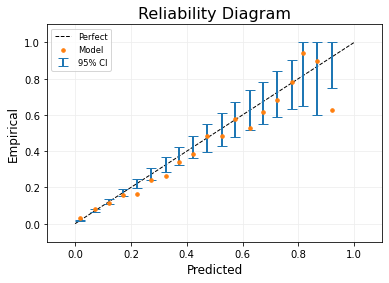

In [19]:
# This is the default plot
# within the error bar is something you're going to see 95% of the time
rd = mli.plot_reliability_diagram(y_test_1, rf1_preds_test_uncalib);

Above we see the default reliability diagram.  While most of the points seem to be within the error bars there are a couple of flaws to point out:
1. Between about .2 and .45 we are consistently over-predicting the mortality.  Though they are right on the edge of the error bar, having many in a row with errors in the same direction indicates this is not random noise.
1. It is hard to see the smaller probabilities well (in the first two bins), but they look like they may be under-predicting.  We will demonstrate how to explore this better

First we will explore some options in the `plot_reliability_diagram` function

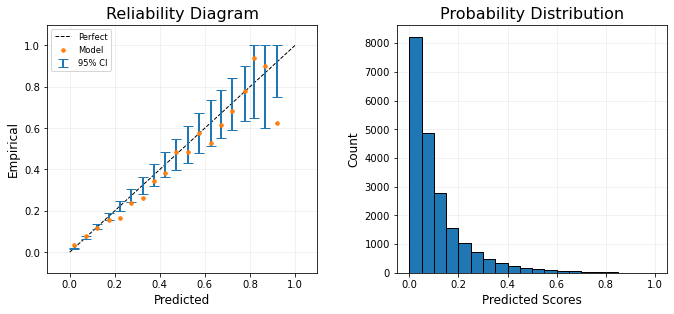

In [20]:
# You can opt to have a histogram showing the counts in each bin
# which is important to give you the context
# you see most of the data falls in left side bins, so if the model is making mistakes
# it's more costly on the left side because most data are on the left side
# so you may want to fix that over-predicting interval between [0.0~0-.2]
# when we have a lot of data, want to split the bin more finer to examine the interval more carefully
# if less data, aggregate the bin more
plt.figure(figsize=(10,5))
mli.plot_reliability_diagram(y_test_1, rf1_preds_test_uncalib, show_histogram=True);

We see that we have lots of observations with small predicted probabilities and fewer with large probabilities.  Suppose we want to subdivide further the bins where we have lots of data, and aggregate the bins that have less data.

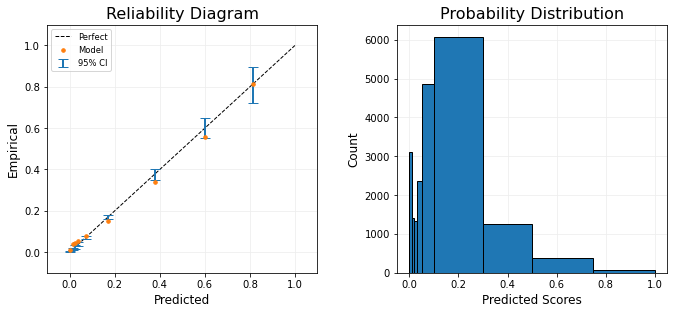

In [21]:

plt.figure(figsize=(10,5))
# breaking up the big bin from 0-0.1 to 5 big bins, keeping the rest the same
custom_bins_a = np.array([0,.01,.02,.03,.05, .1, .3, .5, .75, 1])
mli.plot_reliability_diagram(y_test_1, rf1_preds_test_uncalib, bins=custom_bins_a, show_histogram=True);

Again, we may be underpredicting close to 0, but it is hard to tell.  To look closer, we can use the "logit" scaling.  This scaling uses more area at probabilities close to 0 and 1, and less area close to .5

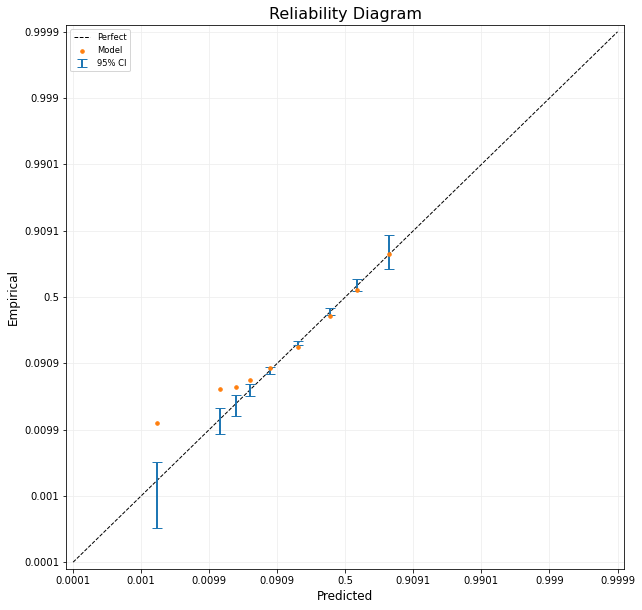

In [22]:
# strech out the area we care so we can look closers
plt.figure(figsize=(10,10))
rd = mli.plot_reliability_diagram(y_test_1, rf1_preds_test_uncalib, scaling='logit',
                                 bins=custom_bins_a, marker='.')

Now we are able to see that we are underpredicting at low probabilities and then overpredicting around .3.  Let's extract a few numbers by looking at the dictionary `rd` returned by the function

In [23]:
rd.keys()

dict_keys(['pred_probs', 'emp_probs', 'bin_counts'])

In [24]:
rd['pred_probs'], rd['emp_probs'], rd['bin_counts']

(array([0.00169018, 0.01399387, 0.02391283, 0.03870504, 0.07247161,
        0.17011314, 0.37707038, 0.60034201, 0.81376316]),
 array([0.01224227, 0.03943662, 0.04223228, 0.05221053, 0.07894737,
        0.14964644, 0.33780584, 0.55867347, 0.81578947]),
 array([3104., 1420., 1326., 2375., 4864., 6081., 1267.,  392.,   76.]))

Here we can see clearly that for the smallest bin, we have an average predicted probability of about .0017 but empirically (on 3089 trials) we have a probability of .012 -- off by a factor of 7!

In [26]:
.012/.0017

7.058823529411765

#### sklearn `calibration_curve`
- Scikit-learn has a function `calibration_curve` that will give the x and y coordinates for a number of bins.
- The rest of the plotting is up to you
- It does not support custom bin widths (October 2020)

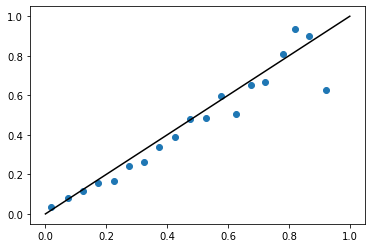

In [27]:
prob_true, prob_pred = calibration_curve(y_test_1, rf1_preds_test_uncalib, n_bins=20)
plt.scatter(prob_pred, prob_true)
plt.plot(np.linspace(0,1,11),np.linspace(0,1,11), color='k')

## Exercise
### It's your turn!
Repeat this process for a bigger set of features below

In [28]:
# Choose a subset of variables

feature_set_2 = feature_set_1 + ['lactate_min', 'lactate_max', 'platelet_min', 'platelet_max',
       'potassium_min', 'potassium_max', 'ptt_min', 'ptt_max', 'inr_min',
       'inr_max']

In [29]:
# Repeat train, calib, test split

X_2 = lab_aug_df.loc[:,feature_set_2]
X_train_calib_2, X_test_2, y_train_calib_2, y_test_2 = train_test_split(X_2, y, test_size=test_perc, random_state=rs)
X_train_2, X_calib_2, y_train_2, y_calib_2 = train_test_split(X_train_calib_2, y_train_calib_2, 
                                                              test_size=calib_perc/(1-test_perc), 
                                                              random_state=rs)

In [30]:
# Fit a Random Forest Model

rfmodel2 = RandomForestClassifier(n_estimators=500, class_weight='balanced_subsample', 
                                  random_state=rs, n_jobs=-1 )
rfmodel2.fit(X_train_2,y_train_2);

In [31]:
rf2_preds_test_uncalib = rfmodel2.predict_proba(X_test_2)[:,1]

In [32]:
roc_auc_score(y_test_2, rf2_preds_test_uncalib), log_loss(y_test_2, rf2_preds_test_uncalib)
# both the roc_auc_score improved, and log_loss decreases(also improved)

(0.827953541822799, 0.2678816479222118)

Use the cells below to explore the calibration of this model.

- Is it well calibrated?
- How does it compare to the previous model?

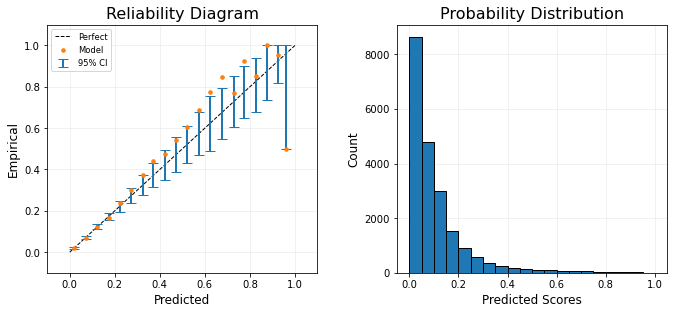

In [35]:
# Plot the default reliability diagram
plt.figure(figsize=(10,5))
mli.plot_reliability_diagram(y_test_2, rf2_preds_test_uncalib, show_histogram=True);

In [30]:
# Display the histogram on the side

# plt.figure(figsize=(8,4))
# mli.plot_reliability_diagram(...);

In [31]:
# Create a custom set of bins

# bins_custom_b = np.array([])
# mli.plot_reliability_diagram(...);


In [32]:
# Use the logit scaling

# plt.figure(figsize=(10,4))
# mli.plot_reliability_diagram(...);

### Extra Credit: 
Fit another kind of model (Boosting, Logistic Regression, etc.) on the same data set and assess the calibration of that model

## Lesson 2: Calibrating a Model
Since our models are not well-calibrated, we would like to fix this.  

### Getting a **Calibration** Data Set

We will discuss two ways to get a data set on which to perform calibration:

- Use an independent calibration set
- Using Cross-validation to generate scores from the training set. (takes more time but more data efficient) : we fit a model on the entire training datasets. Now devide the model into 5 foldes, train on 4/5 of them, leaving 1 fold out each time. Now we have a set of prediction on everything in the dataset, and all of the prediction come from a model that did not see the data.And then we can take that set of scores and treat that as our calibration.

The first method is simpler, but requires a separate data set, meaning that you will have less data to train your model with.  It is good to use if you have plenty of data.

The second approach takes more time, but is generally more data-efficient.  We generate a set of cross-validated predictions on the training data.  These predictions come from models(trained on n-1 folds of data) that are close to, but not exactly identical to, your original model (trained on all data).  However, this discrepancy is usually minor and offset by having more data on which to calibrate.So the faith is that the model train on whole dataset is not going to be too different from those trained on n-1 folds,  if the calibration fixes the n-1 fold model , it will fix the original model. 

### Method of Calibration

The data set for calibration is a set of scores and the corresponding binary outcomes.  The goal is then to find a function that "fits" the relationship between the scores and the "actual" probabilities (as determined empirically in the calibration set.  We will review 4 methods of calibration:

- Platt Scaling
- Isotonic Regression
- Beta Calibration (relatively new)
- SplineCalib (relatively new)


## Approach A: Independent calibration set
Overall process: 
- Need separate training and calibration sets (plus a test set to evaluate)
- Fit model on training set data
- Make predictions on calibration set.
- Use those predictions + true answers to fit a calibration object.
- Use model to make predictions on test set
- Use calibrator to calibrate those predictions
- Evaluate log_loss, reliability diagram on calibrated predictions


In [36]:
calibset_preds_uncalib_1 = rfmodel1.predict_proba(X_calib_1)[:,1]
testset_preds_uncalib_1 = rfmodel1.predict_proba(X_test_1)[:,1]

## Method 1: Platt Scaling
Assumes that there is a logistic relationship between the scores $z$ and the true probability $p$.

$\log\left(\frac{p}{1-p}\right) = \alpha + \beta z$

$p = \frac{1}{1+\exp(-(\alpha + \beta z))}$

So it fits the two parameters $\alpha$ and $\beta$ just like in logistic regression!

- Very restrictive set of possible functions:(if the true relationship is logistic or close to it, this will work quite well; if it's not , it's gonna do poorly)
- It's not intended to be used in general but people use it anyway and a lot of time it does ok
- Needs very little data
- Historically, came from the observation (and subsequent theoretical arguments) that a logistic regression was the "right" calibration for Support Vector Machines

Reference: Platt, J. (1999). Probabilistic outputs for support vector machines and comparison to regularized likelihood methods. Advances in Large Margin Classifiers (pp.61–74).

In [38]:
# Fit Platt scaling (logistic calibration)
# In Sciitt learn, there's no unregularized version of logistic Regression
# by default it does some coefficient shrinkage.
# Bigger C means less regularization, so just set to C to really big to 
# turn off regularization
lr = LogisticRegression(C=99999999999, solver='lbfgs')
lr.fit(calibset_preds_uncalib_1.reshape(-1,1), y_calib_1)


LogisticRegression(C=99999999999)

In [39]:
calibset_platt_probs = lr.predict_proba(calibset_preds_uncalib_1.reshape(-1,1))[:,1]
testset_platt_probs = lr.predict_proba(testset_preds_uncalib_1.reshape(-1,1))[:,1]

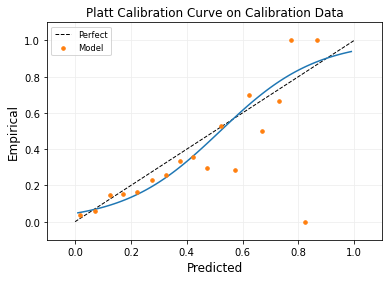

In [40]:
mli.plot_reliability_diagram(y_calib_1,  , error_bars=False);
tvec = np.linspace(.01, .99, 99)
plt.plot(tvec, lr.predict_proba(tvec.reshape(-1,1))[:,1]);
plt.title('Platt Calibration Curve on Calibration Data');
# you can see in the diagram, the curve tries the best to fit the point
# And it's constrained on the form that it needs to be a logistic relationship
#(sigmmoid shaped)
# notice the very left point in diagram, the logistic regressino prediction is above the 
# the actual label y, so it's over predicting.
# you will see correspondingly later in the reliability diagram,
# the calibrated model is overpredicting in left area.

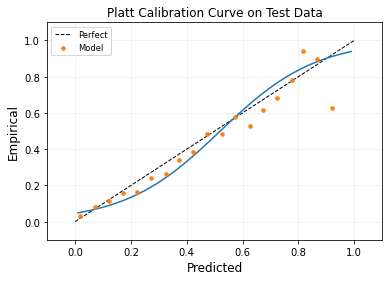

In [41]:
mli.plot_reliability_diagram(y_test_1, testset_preds_uncalib_1, error_bars=False);
tvec = np.linspace(.01, .99, 99)
plt.plot(tvec, lr.predict_proba(tvec.reshape(-1,1))[:,1])
plt.title('Platt Calibration Curve on Test Data');
# The test set is bigger, so the point is not so jumpy 

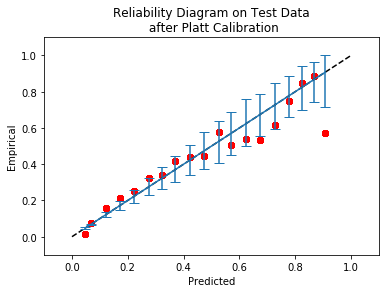

In [38]:
# still you see some points are consistently outside of the error bar

mli.plot_reliability_diagram(y_test_1, testset_platt_probs);
plt.title('Reliability Diagram on Test Data\n after Platt Calibration');

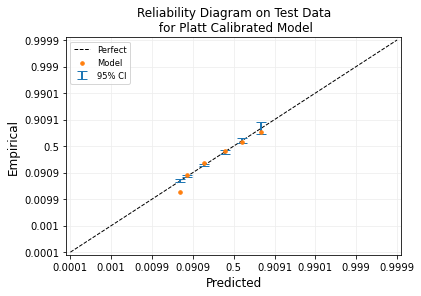

In [42]:
# we are badly missing in the first point
custom_bins_a = np.array([0,.01,.02,.03,.05, .1, .3, .5, .75, 1])
rd = mli.plot_reliability_diagram(y_test_1, testset_platt_probs, scaling='logit', bins=custom_bins_a);
plt.title('Reliability Diagram on Test Data\n for Platt Calibrated Model');

Using the logit scaling, we can see that the calibration does poorly at the small values.

In [43]:
print('Platt calibrated log_loss = {}'.format(log_loss(y_test_1, testset_platt_probs)))
print('Uncalibrated log_loss = {}'.format(log_loss(y_test_1, testset_preds_uncalib_1)))

Platt calibrated log_loss = 0.2978882168226113
Uncalibrated log_loss = 0.31855793458987103


Despite this, we see an improvement in log_loss.  Generally, making mistakes by predicting "closer to .5" is better for log loss (i.e. better to overpredict rare events and underpredict near certain events)

## Method 2: Isotonic Regression
- Fits a piecewise constant, monotonically increasing, function to map the scores to probabilities.
- Uses the PAV (Pool Adjacent Violators, also called PAVA) algorithm.
- Pros: What's nice about it Does not assume a particular parametric form.
- Cons: Tends to be better than Platt scaling with enough data (the downside is it needs a lot of data)
- Cons: Tends to overfit: ("choppy" with unrealistic jumps)

Reference: Zadrozny,  B., & Elkan, C.(2001). Obtaining calibrated probability estimates from decision trees and naive bayesian classifiers. ICML (pp.609–616).

Zadrozny,  B., & Elkan, C. (2002). Transforming classifier scores into accurate multiclass probability estimates. KDD (pp.694–699).

In [44]:
iso = IsotonicRegression(out_of_bounds = 'clip')
iso.fit( , y_calib_1)

IsotonicRegression(out_of_bounds='clip')

In [46]:
calibset_iso_probs = iso.predict(calibset_preds_uncalib_1)
testset_iso_probs = iso.predict(testset_preds_uncalib_1)

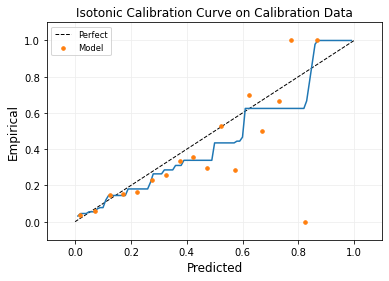

In [51]:
mli.plot_reliability_diagram(y_calib_1, calibset_preds_uncalib_1, error_bars=False);
tvec = np.linspace(.01, .99, 99)
plt.plot(tvec, iso.predict(tvec), label='Isotonic');
plt.title('Isotonic Calibration Curve on Calibration Data');

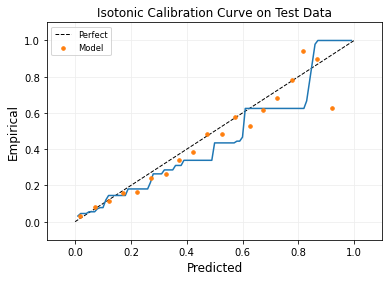

In [48]:
mli.plot_reliability_diagram(y_test_1, testset_preds_uncalib_1, error_bars=False);
tvec = np.linspace(.01, .99, 99)
plt.plot(tvec, iso.predict(tvec), label='Isotonic');
plt.title('Isotonic Calibration Curve on Test Data');

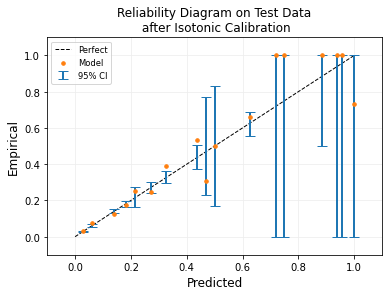

In [49]:
# in the following diagram you see we don't have value in bins like 
# around (0.38~0.42) . a.k.a model did not make prediction that falls in this bins
# refer back to the trained iso curve, you can see that 
# it has a 拐点 at 0,35, then all flat, then jumps to 0,42.matching what we saw in the bin
mli.plot_reliability_diagram(y_test_1, testset_iso_probs);
plt.title('Reliability Diagram on Test Data\n after Isotonic Calibration');

Here we see some of the artifacts of isotonic calibration.  Some bins have few to no points after calibration due to the vertical "steps" in the function.

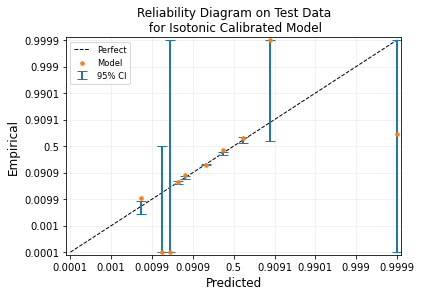

In [52]:
custom_bins_a = np.array([0,.01,.02,.03,.05, .1, .3, .5, .75, 1])
rd = mli.plot_reliability_diagram(y_test_1, testset_iso_probs, scaling='logit', bins=custom_bins_a);
plt.title('Reliability Diagram on Test Data\n for Isotonic Calibrated Model');

In [53]:
print('Isotonic calibrated log_loss = {}'.format(log_loss(y_test_1, testset_iso_probs)))
print('Platt calibrated log_loss = {}'.format(log_loss(y_test_1, testset_platt_probs)))
print('Uncalibrated log_loss = {}'.format(log_loss(y_test_1, testset_preds_uncalib_1)))

Isotonic calibrated log_loss = 0.30150781498010176
Platt calibrated log_loss = 0.2978882168226113
Uncalibrated log_loss = 0.31855793458987103


## Method 3: Beta Calibration

"A well-founded and easily implemented improvement on logistic calibration for binary classifiers."

$p = \left(1+ 1 / \left( \exp(c) \frac{z^a}{(1-z)^b} \right) \right)^{-1}$

- Similar to Platt scaling with a couple of important improvements
- Is a 3-parameter family of curves rather than 2-parameter
- Family of curves *includes* the line $y=x$ (so it won't mess it up if it's already calibrated)

Reference: Kull, M., Filho, T.S. & Flach, P.. (2017). Beta calibration: a well-founded and easily implemented improvement on logistic calibration for binary classifiers. Proceedings of the 20th International Conference on Artificial Intelligence and Statistics, in PMLR 54:623-631 

In [54]:
# Fit three-parameter beta calibration
bc = BetaCalibration()
bc.fit(calibset_preds_uncalib_1, y_calib_1)


BetaCalibration()

In [59]:
calibset_bc_probs = bc.predict(calibset_preds_uncalib_1)
testset_bc_probs = bc.predict(testset_preds_uncalib_1)


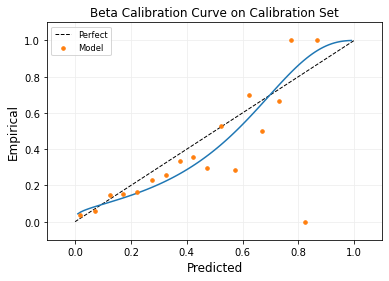

In [57]:
mli.plot_reliability_diagram(y_calib_1, calibset_preds_uncalib_1, error_bars=False);
tvec = np.linspace(.01, .99, 99)
plt.plot(tvec, bc.predict(tvec))
plt.title('Beta Calibration Curve on Calibration Set');

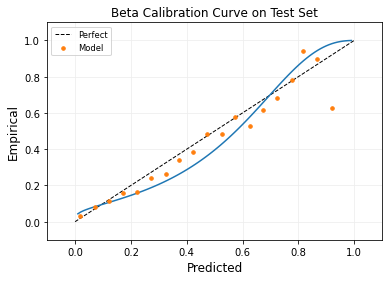

In [58]:
mli.plot_reliability_diagram(y_test_1, testset_preds_uncalib_1, error_bars=False);
tvec = np.linspace(.01, .99, 99)
plt.plot(tvec, bc.predict(tvec))
plt.title('Beta Calibration Curve on Test Set');

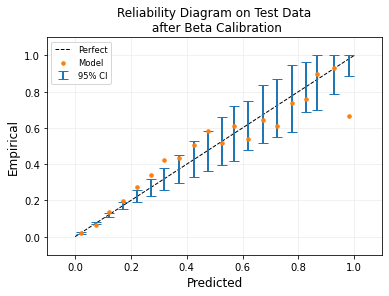

In [60]:
mli.plot_reliability_diagram(y_test_1, testset_bc_probs);
plt.title('Reliability Diagram on Test Data\n after Beta Calibration');

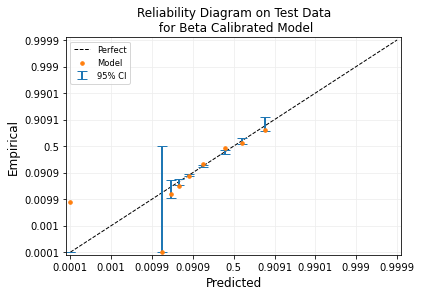

In [61]:
custom_bins_a = np.array([0,.01,.02,.03,.05, .1, .3, .5, .75, 1])
rd = mli.plot_reliability_diagram(y_test_1, testset_bc_probs, scaling='logit', bins=custom_bins_a);
plt.title('Reliability Diagram on Test Data\n for Beta Calibrated Model');

In [62]:
print('Beta calibrated log_loss = {}'.format(log_loss(y_test_1, testset_bc_probs)))
print('Isotonic calibrated log_loss = {}'.format(log_loss(y_test_1, testset_iso_probs)))
print('Platt calibrated log_loss = {}'.format(log_loss(y_test_1, testset_platt_probs)))
print('Uncalibrated log_loss = {}'.format(log_loss(y_test_1, testset_preds_uncalib_1)))

Beta calibrated log_loss = 0.2996256723439284
Isotonic calibrated log_loss = 0.30150781498010176
Platt calibrated log_loss = 0.2978882168226113
Uncalibrated log_loss = 0.31855793458987103


## Method 4: SplineCalib 
- SplineCalib fits a cubic smoothing spline to the relationship between the uncalibrated scores and the calibrated probabilities
- Smoothing splines strike a balance between fitting the points well and having a smooth function
- SplineCalib uses a smoothed logistic function - so the fit to data is measured by likelihood (i.e. log-loss) and the smoothness refers to the integrated second derivative **before** the logistic transformation.
- There is a nuisance parameter that trades off smoothness for fit.  At one extreme it will revert to standard logistic regression (i.e. Platt scaling) and at the other extreme it will be a very wiggly function that fits the data but does not generalize well.

- SplineCalib automatically fits the nuisance parameter (though this can be adjusted by the user)
- The resulting calibration function is not necessarily monotonic.  (In some cases this may be beneficial).

References: Lucena, B. Spline-based Probability Calibration. https://arxiv.org/abs/1809.07751

In [63]:
# Define SplineCalib object
splinecalib = mli.SplineCalib()
splinecalib.fit(calibset_preds_uncalib_1, y_calib_1)

In [64]:
calibset_splinecalib_probs = splinecalib.predict(calibset_preds_uncalib_1)
testset_splinecalib_probs = splinecalib.predict(testset_preds_uncalib_1)


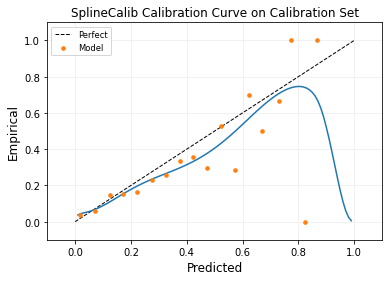

In [65]:
mli.plot_reliability_diagram(y_calib_1, calibset_preds_uncalib_1, error_bars=False);
tvec = np.linspace(.01, .99, 99)
plt.plot(tvec, splinecalib.predict(tvec))
plt.title('SplineCalib Calibration Curve on Calibration Set');

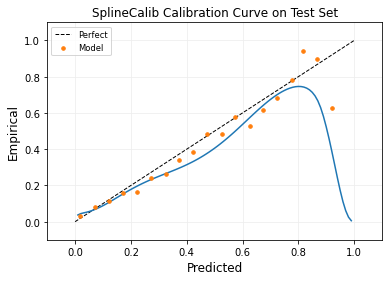

In [66]:
mli.plot_reliability_diagram(y_test_1, testset_preds_uncalib_1, error_bars=False);
tvec = np.linspace(.01, .99, 99)
plt.plot(tvec, splinecalib.predict(tvec))
plt.title('SplineCalib Calibration Curve on Test Set');

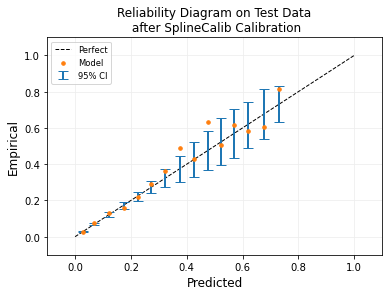

In [67]:
mli.plot_reliability_diagram(y_test_1, testset_splinecalib_probs);
plt.title('Reliability Diagram on Test Data\n after SplineCalib Calibration');

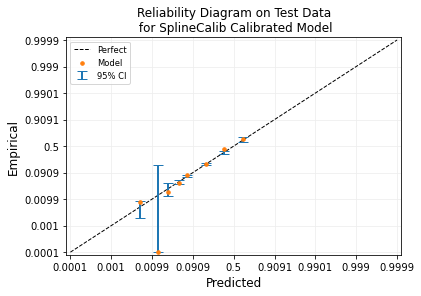

In [68]:
custom_bins_a = np.array([0,.01,.02,.03,.05, .1, .3, .5, .75, 1])
rd = mli.plot_reliability_diagram(y_test_1, testset_splinecalib_probs, scaling='logit', bins=custom_bins_a);
plt.title('Reliability Diagram on Test Data\n for SplineCalib Calibrated Model');

In [69]:
print('Spline calibrated log_loss = {}'.format(log_loss(y_test_1, testset_splinecalib_probs)))
print('Beta calibrated log_loss = {}'.format(log_loss(y_test_1, testset_bc_probs)))
print('Isotonic calibrated log_loss = {}'.format(log_loss(y_test_1, testset_iso_probs)))
print('Platt calibrated log_loss = {}'.format(log_loss(y_test_1, testset_platt_probs)))
print('Uncalibrated log_loss = {}'.format(log_loss(y_test_1, testset_preds_uncalib_1)))

Spline calibrated log_loss = 0.2938992791116666
Beta calibrated log_loss = 0.2996256723439284
Isotonic calibrated log_loss = 0.30150781498010176
Platt calibrated log_loss = 0.2978882168226113
Uncalibrated log_loss = 0.31855793458987103


On this example, SplineCalib does best, though Beta calibration and Platt scaling both do reasonably well (and are quicker to fit).  Isotonic does relatively poorly.  Note that we used only about 3K data points in our calibration set - Isotonic regression is relatively "data-hungry"

Below, we can see the results measured by Brier Score loss.  Note that there may be a very different pattern here in relative performance of the methods.

In [70]:
print('Spline calibrated Brier Score = {}'.format(brier_score_loss(y_test_1, testset_splinecalib_probs)))
print('Beta calibrated Brier Score = {}'.format(brier_score_loss(y_test_1, testset_bc_probs)))
print('Isotonic calibrated Brier Score = {}'.format(brier_score_loss(y_test_1, testset_iso_probs)))
print('Platt calibrated Brier Score = {}'.format(brier_score_loss(y_test_1, testset_platt_probs)))
print('Uncalibrated Brier Score = {}'.format(brier_score_loss(y_test_1, testset_preds_uncalib_1)))

Spline calibrated Brier Score = 0.0846440021916228
Beta calibrated Brier Score = 0.0849303835686229
Isotonic calibrated Brier Score = 0.08502804533665388
Platt calibrated Brier Score = 0.0849869247983427
Uncalibrated Brier Score = 0.08482361681729395


## Your Turn
Calibrate the `rfmodel2` using a couple (or all) of the methods given above.  Compare their performances.  Feel free to cut and paste from above, but try to think about the steps you are doing so it makes sense.

Note that you may get very different results from what happened for `rfmodel1`.

## Approach 2: Cross-validation on the training data
The reason to use an independent calibration set (rather than just the training data) is that how the model performs on the training data (that it has already seen) is not indicative of how it will behave on data it has not seen before.  We want the calibration to correct how the model will behave on "new" data, not the training data.

Another approach is to take a cross-validation approach to generating calibration data.  We divide the training data into k "folds", leave one fold out, train our model (i.e. the choice of model and hyperparameter settings) on the remaining k-1 folds, and then make predictions on the left-out fold.  After doing this process k times, each time leaving out a different fold, we will have a set of predictions, each of which was generated by 1 of k slightly different models, but was always generated by a model that did not see that training point.  Done properly (assuming no "leakage" across the folds), this set of predictions and answers will serve as an appropriate calibration set.

- Advantages: more data for both training *and* calibration.
- Disadvantages: Must train k+1 models.  Also, the calibration data does not come from the exact same model you will be using it on.

ML-Insights (the package containing SplineCalib, as well as other functionality) has a simple function to generate these cross-validated predictions.  We demonstrate it below.

In [63]:
# Get the cross validated predictions given a model and training data.
cv_preds_train = mli.cv_predictions(rfmodel1, X_train_1, y_train_1, clone_model=True)
cv_preds_train1 = cv_preds_train[:,1]

### Platt scaling with CV Data

In [64]:
# Fit Platt scaling (logistic calibration)
lr_cv = LogisticRegression(C=99999999999, solver='lbfgs')
lr_cv.fit(cv_preds_train1.reshape(-1,1), y_train_1)


LogisticRegression(C=99999999999, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [65]:
testset_platt_probs_cv = lr_cv.predict_proba(testset_preds_uncalib_1.reshape(-1,1))[:,1]

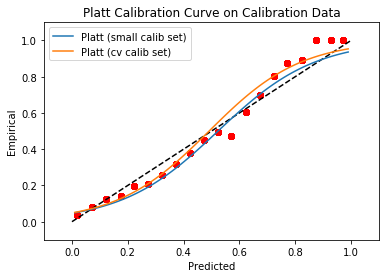

In [66]:
mli.plot_reliability_diagram(y_train_1, cv_preds_train1, error_bars=False);
tvec = np.linspace(.01, .99, 99)
plt.plot(tvec, lr.predict_proba(tvec.reshape(-1,1))[:,1], label='Platt (small calib set)')
plt.plot(tvec, lr_cv.predict_proba(tvec.reshape(-1,1))[:,1], label='Platt (cv calib set)')
plt.title('Platt Calibration Curve on Calibration Data');
plt.legend();

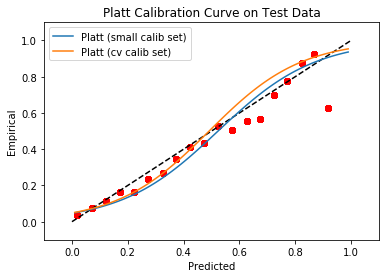

In [67]:
mli.plot_reliability_diagram(y_test_1, testset_preds_uncalib_1, error_bars=False);
tvec = np.linspace(.01, .99, 99)
plt.plot(tvec, lr.predict_proba(tvec.reshape(-1,1))[:,1], label='Platt (small calib set)')
plt.plot(tvec, lr_cv.predict_proba(tvec.reshape(-1,1))[:,1], label='Platt (cv calib set)')
plt.title('Platt Calibration Curve on Test Data');
plt.legend();

We see that the two curves are not very different.  Since Platt scaling fits just two parameters, the function does not change much with more data.  The upside is that you don't need a lot of calibration data to use Platt scaling!

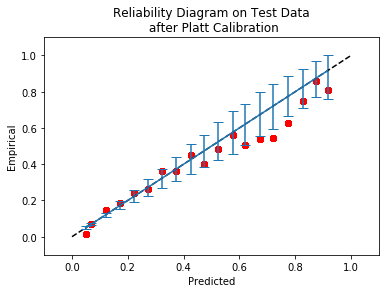

In [68]:
mli.plot_reliability_diagram(y_test_1, testset_platt_probs_cv);
plt.title('Reliability Diagram on Test Data\n after Platt Calibration');

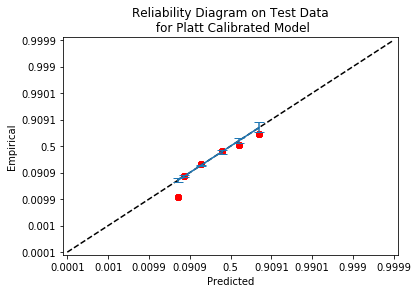

In [69]:
custom_bins_a = np.array([0,.01,.02,.03,.05, .1, .3, .5, .75, 1])
rd = mli.plot_reliability_diagram(y_test_1, testset_platt_probs_cv, scaling='logit', bins=custom_bins_a);
plt.title('Reliability Diagram on Test Data\n for Platt Calibrated Model');

In [70]:
print('Platt calibrated log_loss = {}'.format(log_loss(y_test_1, testset_platt_probs_cv)))
print('Uncalibrated log_loss = {}'.format(log_loss(y_test_1, testset_preds_uncalib_1)))

Platt calibrated log_loss = 0.2980753769991345
Uncalibrated log_loss = 0.31209048301332465


Having extra data did not really change our results



### Isotonic with CV data

In [71]:
iso_cv = IsotonicRegression(out_of_bounds = 'clip')
iso_cv.fit(cv_preds_train1, y_train_1)

IsotonicRegression(increasing=True, out_of_bounds='clip', y_max=None,
                   y_min=None)

In [72]:
testset_iso_probs_cv = iso_cv.predict(testset_preds_uncalib_1)

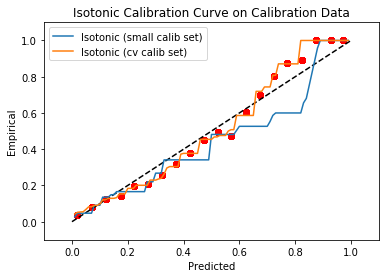

In [73]:
mli.plot_reliability_diagram(y_train_1, cv_preds_train1, error_bars=False);
tvec = np.linspace(.01, .99, 99)
plt.plot(tvec, iso.predict(tvec), label='Isotonic (small calib set)');
plt.plot(tvec, iso_cv.predict(tvec), label='Isotonic (cv calib set)');
plt.title('Isotonic Calibration Curve on Calibration Data');
plt.legend();

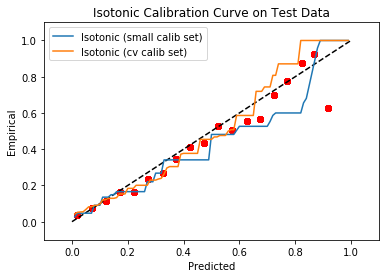

In [74]:
mli.plot_reliability_diagram(y_test_1, testset_preds_uncalib_1, error_bars=False);
tvec = np.linspace(.01, .99, 99)
plt.plot(tvec, iso.predict(tvec), label='Isotonic (small calib set)');
plt.plot(tvec, iso_cv.predict(tvec), label='Isotonic (cv calib set)');
plt.title('Isotonic Calibration Curve on Test Data');
plt.legend();

We see above, that with more data, the Isotonic regression fits the test data better, particularly in the middle of the range.  Qualitatively, the vertical jumps are less extreme.

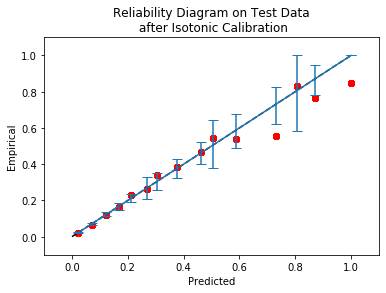

In [75]:
mli.plot_reliability_diagram(y_test_1, testset_iso_probs_cv);
plt.title('Reliability Diagram on Test Data\n after Isotonic Calibration');

The isotonic regression appears to have benefitted from the extra calibration data.

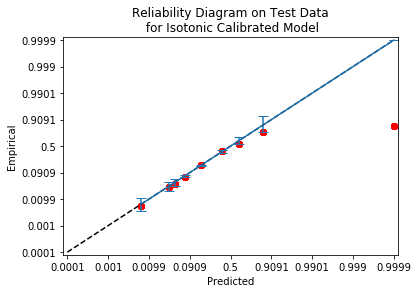

In [76]:
custom_bins_a = np.array([0,.01,.02,.03,.05, .1, .3, .5, .75, 1])
rd = mli.plot_reliability_diagram(y_test_1, testset_iso_probs_cv, scaling='logit', bins=custom_bins_a);
plt.title('Reliability Diagram on Test Data\n for Isotonic Calibrated Model');

In [77]:
print('Isotonic calibrated log_loss = {}'.format(log_loss(y_test_1, testset_iso_probs_cv)))
print('Platt calibrated log_loss = {}'.format(log_loss(y_test_1, testset_platt_probs_cv)))
print('Uncalibrated log_loss = {}'.format(log_loss(y_test_1, testset_preds_uncalib_1)))

Isotonic calibrated log_loss = 0.3031159383649809
Platt calibrated log_loss = 0.2980753769991345
Uncalibrated log_loss = 0.31209048301332465


With the larger data set we see much better performance from isotonic regression.

### Beta with CV data

In [78]:
# Fit three-parameter beta calibration
bc_cv = BetaCalibration()
bc_cv.fit(cv_preds_train1, y_train_1)


BetaCalibration(parameters=None)

In [79]:
testset_bc_probs_cv = bc_cv.predict(testset_preds_uncalib_1)


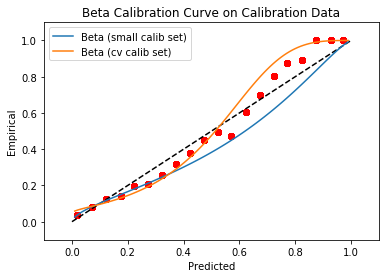

In [80]:
mli.plot_reliability_diagram(y_train_1, cv_preds_train1, error_bars=False);
tvec = np.linspace(.01, .99, 99)
plt.plot(tvec, bc.predict(tvec), label='Beta (small calib set)')
plt.plot(tvec, bc_cv.predict(tvec), label='Beta (cv calib set)')
plt.title('Beta Calibration Curve on Calibration Data');
plt.legend();

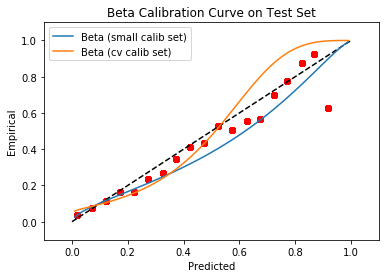

In [81]:
mli.plot_reliability_diagram(y_test_1, testset_preds_uncalib_1, error_bars=False);
tvec = np.linspace(.01, .99, 99)
plt.plot(tvec, bc.predict(tvec), label='Beta (small calib set)')
plt.plot(tvec, bc_cv.predict(tvec), label='Beta (cv calib set)')
plt.title('Beta Calibration Curve on Test Set');
plt.legend();

We see a small difference in the curves, but not a huge change from having 3K points vs 45K points to learn from

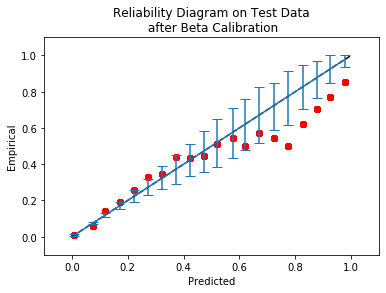

In [82]:
mli.plot_reliability_diagram(y_test_1, testset_bc_probs_cv);
plt.title('Reliability Diagram on Test Data\n after Beta Calibration');

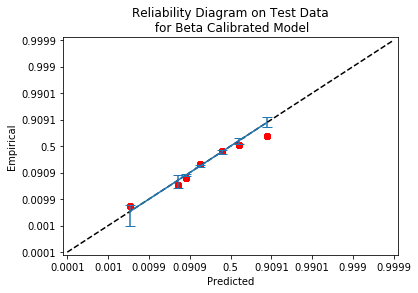

In [83]:
custom_bins_a = np.array([0,.01,.02,.03,.05, .1, .3, .5, .75, 1])
rd = mli.plot_reliability_diagram(y_test_1, testset_bc_probs_cv, scaling='logit', bins=custom_bins_a);
plt.title('Reliability Diagram on Test Data\n for Beta Calibrated Model');

Not much of a change from the smaller calib set

In [84]:
print('Beta calibrated log_loss = {}'.format(log_loss(y_test_1, testset_bc_probs_cv)))
print('Isotonic calibrated log_loss = {}'.format(log_loss(y_test_1, testset_iso_probs_cv)))
print('Platt calibrated log_loss = {}'.format(log_loss(y_test_1, testset_platt_probs_cv)))
print('Uncalibrated log_loss = {}'.format(log_loss(y_test_1, testset_preds_uncalib_1)))

Beta calibrated log_loss = 0.2972470914743036
Isotonic calibrated log_loss = 0.3031159383649809
Platt calibrated log_loss = 0.2980753769991345
Uncalibrated log_loss = 0.31209048301332465


Now, Beta calibration does slightly better than Platt scaling.  Isotonic has improved.

### SplineCalib with CV data

In [85]:
splinecalib_cv = mli.SplineCalib()
splinecalib_cv.fit(cv_preds_train, y_train_1)

In [86]:
testset_splinecalib_probs_cv = splinecalib_cv.predict(testset_preds_uncalib_1)

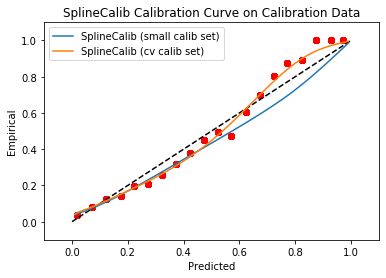

In [87]:
mli.plot_reliability_diagram(y_train_1, cv_preds_train1, error_bars=False);
tvec = np.linspace(.01, .99, 99)
plt.plot(tvec, splinecalib.predict(tvec), label='SplineCalib (small calib set)')
plt.plot(tvec, splinecalib_cv.predict(tvec), label='SplineCalib (cv calib set)')
plt.title('SplineCalib Calibration Curve on Calibration Data');
plt.legend();

With the larger data set, the calibration curve is now close to the line y=x

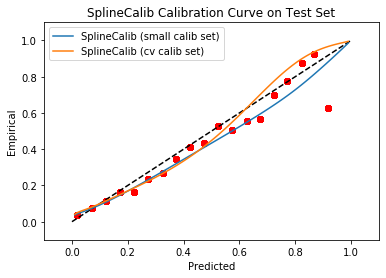

In [88]:
mli.plot_reliability_diagram(y_test_1, testset_preds_uncalib_1, error_bars=False);
tvec = np.linspace(.01, .99, 99)
plt.plot(tvec, splinecalib.predict(tvec), label='SplineCalib (small calib set)')
plt.plot(tvec, splinecalib_cv.predict(tvec), label='SplineCalib (cv calib set)')
plt.title('SplineCalib Calibration Curve on Test Set');
plt.legend();

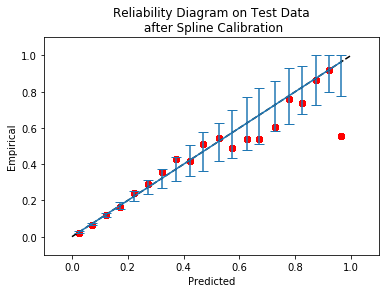

In [89]:
mli.plot_reliability_diagram(y_test_1, testset_splinecalib_probs_cv);
plt.title('Reliability Diagram on Test Data\n after Spline Calibration');

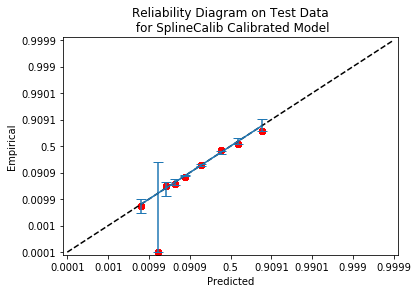

In [90]:
custom_bins_a = np.array([0,.01,.02,.03,.05, .1, .3, .5, .75, 1])
rd = mli.plot_reliability_diagram(y_test_1, testset_splinecalib_probs_cv, scaling='logit', bins=custom_bins_a);
plt.title('Reliability Diagram on Test Data\n for SplineCalib Calibrated Model');

The points are very close to the line y=x

In [91]:
print('Spline calibrated log_loss = {}'.format(log_loss(y_test_1, testset_splinecalib_probs_cv)))
print('Beta calibrated log_loss = {}'.format(log_loss(y_test_1, testset_bc_probs_cv)))
print('Isotonic calibrated log_loss = {}'.format(log_loss(y_test_1, testset_iso_probs_cv)))
print('Platt calibrated log_loss = {}'.format(log_loss(y_test_1, testset_platt_probs_cv)))
print('Uncalibrated log_loss = {}'.format(log_loss(y_test_1, testset_preds_uncalib_1)))

Spline calibrated log_loss = 0.2938099296324512
Beta calibrated log_loss = 0.2972470914743036
Isotonic calibrated log_loss = 0.3031159383649809
Platt calibrated log_loss = 0.2980753769991345
Uncalibrated log_loss = 0.31209048301332465


In [92]:
print('Spline calibrated Brier Score = {}'.format(brier_score_loss(y_test_1, testset_splinecalib_probs_cv)))
print('Beta calibrated Brier Score = {}'.format(brier_score_loss(y_test_1, testset_bc_probs_cv)))
print('Isotonic calibrated Brier Score = {}'.format(brier_score_loss(y_test_1, testset_iso_probs_cv)))
print('Platt calibrated Brier Score = {}'.format(brier_score_loss(y_test_1, testset_platt_probs_cv)))
print('Uncalibrated Brier Score = {}'.format(brier_score_loss(y_test_1, testset_preds_uncalib_1)))

Spline calibrated Brier Score = 0.08464770699590742
Beta calibrated Brier Score = 0.085288767598558
Isotonic calibrated Brier Score = 0.08480539303012971
Platt calibrated Brier Score = 0.08511128351457842
Uncalibrated Brier Score = 0.0849214801158517


## Your Turn


- Use the `mli.cv_predictions` functions on `rfmodel2` to create a cross-validated set on which to fit your calibration.

- Then calibrate `rfmodel2` using this set, rather than the separate calibration set.  Compare the results.

- How do the results compare to `rfmodel1`? 

## Extra Credit
- Make a copy of the original notebook.  Change the random state `rs` in cell [5] and then do "Kernel->Restart and Run All".  Observe how the relative performance changes for the different methods both using the calibration set and the cross-validated approach

- Adjust the training and calibration sizes and see how it affects the performances.

### Some things you might notice
- Isotonic Regression can be quite variable - especially with smaller calibration sets.
- Isotonic Regression tends to improve quite a bit as it gets more data
- Beta Calibration tends to beat Platt Scaling (though not always)
- The rankings for log-loss are often not the same as for Brier Score